In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#| default_exp dl.utils.relative_positional
from nbdev.showdoc import show_doc

In ["Swin Transformer: Hierarchical Vision Transformer using Shifted Windows"] (https://arxiv.org/pdf/2103.14030.pdf), the relative positional encoding is used to capture translation invariance. In this notebook, we will implement it from scratch.


In [3]:
import torch

In [18]:
def naive_2d_relative_distance(w_size):
    # tensor for storing it
    distances = torch.zeros([w_size, w_size, w_size, w_size, 2])
    
    for i in range(w_size):
        for j in range(w_size):
            for k in range(w_size):
                for l in range(w_size):
                    # row difference
                    distances[i, j, k, l, 0] = k - i
                    # col diffrence
                    distances[i, j, k, l, 1] = l - j
    return distances    

In [19]:
W = 3
d = naive_2d_relative_distance(W)
d = d.view(W*W, W*W, -1)
d[8, 0:3, :]

tensor([[-2., -2.],
        [-2., -1.],
        [-2.,  0.]])

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_images(images):
    n: int = len(images)
    f = plt.figure()
    for i in range(n):
        # Debug, plot figure
        ax = f.add_subplot(1, n, i + 1)
        ax.set_title(f'Channel {i}')
        sns.heatmap(images[i], annot=images[i], square=True, cbar=False)

    
    plt.show(block=True)

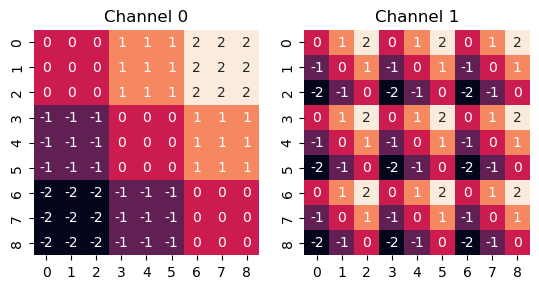

In [22]:
show_images(d.permute(2, 0, 1))

In [31]:
def get_2d_relative_distances(w_size):
    # (w_size*w_size, 2)
    indices = torch.tensor([[x, y] for x in range(w_size) for y in range(w_size)])
    # (w_size*w_size, w_size*w_size, 2)
    # the first (col dim) expand across row
    # the second (row dim) exp
    distances = indices[None, :, :] - indices[:, None, :]
    return distances

In [32]:
d1 = get_2d_relative_distances(W)
d1

tensor([[[ 0,  0],
         [ 0,  1],
         [ 0,  2],
         [ 1,  0],
         [ 1,  1],
         [ 1,  2],
         [ 2,  0],
         [ 2,  1],
         [ 2,  2]],

        [[ 0, -1],
         [ 0,  0],
         [ 0,  1],
         [ 1, -1],
         [ 1,  0],
         [ 1,  1],
         [ 2, -1],
         [ 2,  0],
         [ 2,  1]],

        [[ 0, -2],
         [ 0, -1],
         [ 0,  0],
         [ 1, -2],
         [ 1, -1],
         [ 1,  0],
         [ 2, -2],
         [ 2, -1],
         [ 2,  0]],

        [[-1,  0],
         [-1,  1],
         [-1,  2],
         [ 0,  0],
         [ 0,  1],
         [ 0,  2],
         [ 1,  0],
         [ 1,  1],
         [ 1,  2]],

        [[-1, -1],
         [-1,  0],
         [-1,  1],
         [ 0, -1],
         [ 0,  0],
         [ 0,  1],
         [ 1, -1],
         [ 1,  0],
         [ 1,  1]],

        [[-1, -2],
         [-1, -1],
         [-1,  0],
         [ 0, -2],
         [ 0, -1],
         [ 0,  0],
         [ 1, -2],
  

In [33]:
d1.shape

torch.Size([9, 9, 2])

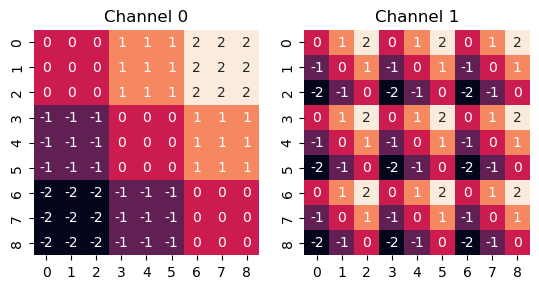

In [34]:
show_images(d1.permute(2, 0, 1))

In [50]:
# offical implementation

def get_2d_relative_coord(w_size):
    coords_h = torch.arange(w_size)
    coords_w = torch.arange(w_size)
    coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing='ij'))  # 2, Wh, Ww
    coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
    # this corresponding row dimension relative to col dimension
    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
    return relative_coords

In [40]:
coords_h = torch.arange(W)
coords_w = torch.arange(W)
coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing='ij')) 

In [42]:
coords

tensor([[[0, 0, 0],
         [1, 1, 1],
         [2, 2, 2]],

        [[0, 1, 2],
         [0, 1, 2],
         [0, 1, 2]]])

In [43]:
coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
coords_flatten

tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2],
        [0, 1, 2, 0, 1, 2, 0, 1, 2]])

In [44]:
relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
relative_coords

tensor([[[ 0,  0,  0, -1, -1, -1, -2, -2, -2],
         [ 0,  0,  0, -1, -1, -1, -2, -2, -2],
         [ 0,  0,  0, -1, -1, -1, -2, -2, -2],
         [ 1,  1,  1,  0,  0,  0, -1, -1, -1],
         [ 1,  1,  1,  0,  0,  0, -1, -1, -1],
         [ 1,  1,  1,  0,  0,  0, -1, -1, -1],
         [ 2,  2,  2,  1,  1,  1,  0,  0,  0],
         [ 2,  2,  2,  1,  1,  1,  0,  0,  0],
         [ 2,  2,  2,  1,  1,  1,  0,  0,  0]],

        [[ 0, -1, -2,  0, -1, -2,  0, -1, -2],
         [ 1,  0, -1,  1,  0, -1,  1,  0, -1],
         [ 2,  1,  0,  2,  1,  0,  2,  1,  0],
         [ 0, -1, -2,  0, -1, -2,  0, -1, -2],
         [ 1,  0, -1,  1,  0, -1,  1,  0, -1],
         [ 2,  1,  0,  2,  1,  0,  2,  1,  0],
         [ 0, -1, -2,  0, -1, -2,  0, -1, -2],
         [ 1,  0, -1,  1,  0, -1,  1,  0, -1],
         [ 2,  1,  0,  2,  1,  0,  2,  1,  0]]])

In [53]:
d2 = get_2d_relative_coord(W)

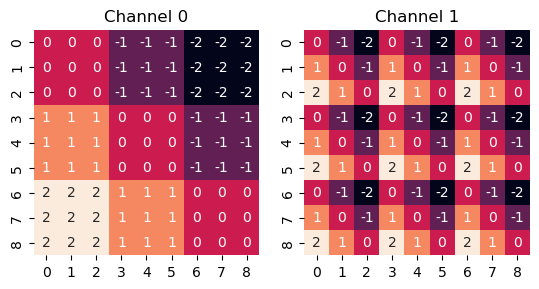

In [52]:
# Note the official implementation is row dimension relative to col dimension
show_images(d2)